In [440]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import tweepy
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.rinterface
%matplotlib inline

## Gather

In [441]:
# twitter scrapper

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [442]:
# Ingest Data

dog_predictions = pd.read_csv("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv", sep='\t')
dog_data = pd.read_csv("twitter-archive-enhanced.csv")

In [443]:
# List of tweets to scrape

tweets = dog_predictions["tweet_id"]

In [444]:
# Scraper (turned off)

'''array = []
with open("tweet_json.txt", "w+") as file:
    for tweet in tweets:
        try:
            array.append(api.get_status(tweet, tweet_mode="extended")._json)
        except tweepy.TweepError as te:
            print("failed")
    json.dump(array, file, indent=True)'''

'array = []\nwith open("tweet_json.txt", "w+") as file:\n    for tweet in tweets:\n        try:\n            array.append(api.get_status(tweet, tweet_mode="extended")._json)\n        except tweepy.TweepError as te:\n            print("failed")\n    json.dump(array, file, indent=True)'

In [445]:
# Load the data from the text document

data = json.load(open("tweet_json.txt", 'r'))        

In [446]:
# Create a dataframe from the twitter data

df_list = []
for json in data:
    df_list.append({"tweet_id": json["id"],
                    "retweets": json["retweet_count"], 
                    "favorites": json["favorite_count"]})
    
tweet_data = pd.DataFrame(df_list, columns=['tweet_id', 'retweets', 'favorites'])

## Assess

In [447]:
tweet_data.head()

,tweet_id,retweets,favorites
0,666020888022790149,517,2565
1,666029285002620928,47,130
2,666033412701032449,44,125
3,666044226329800704,141,298
4,666049248165822465,41,109


In [448]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 3 columns):
tweet_id     2068 non-null int64
retweets     2068 non-null int64
favorites    2068 non-null int64
dtypes: int64(3)
memory usage: 48.5 KB


2068 rows with 3 columns

Lots of missing data. Let us examine this

In [449]:
dog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [450]:
dog_data[dog_data['in_reply_to_status_id'].notnull()]["text"]

30      @NonWhiteHat @MayhewMayhem omg hello tanner yo...
55      @roushfenway These are good dogs but 17/10 is ...
64                        @RealKentMurphy 14/10 confirmed
113     @ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...
148     @Jack_Septic_Eye I'd need a few more pics to p...
149     Ladies and gentlemen... I found Pipsy. He may ...
179                          @Marc_IRL pixelated af 12/10
184     THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...
186     @xianmcguire @Jenna_Marbles Kardashians wouldn...
188     @dhmontgomery We also gave snoop dogg a 420/10...
189     @s8n You tried very hard to portray this good ...
218     @markhoppus MARK THAT DOG HAS SEEN AND EXPERIE...
228     Jerry just apuppologized to me. He said there ...
234     .@breaannanicolee PUPDATE: Cannon has a heart ...
251     PUPDATE: I'm proud to announce that Toby is 23...
274     @0_kelvin_0 &gt;10/10 is reserved for puppos s...
290                                    @markhoppus 182/10
291     @bragg

I'm going to drop the following columns from dog_data

- in_reply_to_status_id
- in_reply_to_user_id
- retweeted_status_id
- retweeted_status_user_id
- retweeted_status_timestamp

I also need to remove the html from source

I will also remove the ratings and img url from link because I already have them elsewhere

I will make a separate hashtag column

In [451]:
dog_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


I'm going to rename the p1, p2, p3 to make it clearer those are the most likely dogs

- prediction_1
- prediction_2
- prediction_3

I'm going to rename the p1_dog, p2_dog, p3_dog to make it clearer they are predicting dogs or not

- predicted_dog_1
- predicted_dog_2
- predicted_dog_3

In [452]:
# check for duplicates

dog_data[dog_data.duplicated()]
dog_predictions[dog_predictions.duplicated()]
tweet_data[tweet_data.duplicated()]

,tweet_id,retweets,favorites


no duplicates

In [453]:
dog_data[dog_data["retweeted_status_user_id"].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


Actually, it turns out retweets are duplicates

I will remove the retweets

In [454]:
dog_data["source"].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

I'm going to use the beautifulsoup library to get the stuff inside the a tag

## Clean

In [455]:
# create copies

dog_data_clean = dog_data.copy()
dog_predictions_clean = dog_predictions.copy()
tweet_data_clean = tweet_data.copy()

In [456]:
# remove retweets

dog_data_clean = dog_data_clean[dog_data_clean["retweeted_status_user_id"].isnull()]

In [457]:
# drop columns

dog_data_clean.drop(["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], axis=1, inplace=True)

In [458]:
# create hashtags column

dog_data_clean["hashtags"] = dog_data_clean["text"].apply(lambda x: re.findall(r'[#]\w+', x))
dog_data_clean["hashtags"] = dog_data_clean["hashtags"].apply(lambda x: ", ".join(x))

In [459]:
# remove ratings and url from text

dog_data_clean["text"] = dog_data_clean["text"].apply(lambda x:x.split('.')[:-2])
dog_data_clean["text"] = dog_data_clean["text"].apply(lambda x:",".join(x))

In [460]:
# Add none for empty hashtags

def fill_hashtags(data):
    if data["hashtags"] == "":
        return None
    else:
        return data["hashtags"]
    
dog_data_clean['hashtags'] = dog_data_clean.apply(fill_hashtags, axis=1)

In [461]:
# Remove html from source

dog_data_clean["source"] = dog_data_clean["source"].apply(lambda x: BeautifulSoup(x, "lxml").get_text())

In [462]:
dog_data_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,hashtags
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,"This is Phineas, He's a mystical boy, Only eve...",https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,"This is Tilly, She's just checking pup on you,...",https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,"This is Archie, He is a rare Norwegian Pouncin...",https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,"This is Darla, She commenced a snooze mid meal",https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,"This is Franklin, He would like you to stop ca...",https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,#BarkWeek
5,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None,#BarkWeek
6,890971913173991426,2017-07-28 16:27:12 +0000,Twitter for iPhone,"Meet Jax, He enjoys ice cream so much he gets ...","https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40 +0000,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51 +0000,Twitter for iPhone,"This is Zoey, She doesn't want to be one of th...",https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None,#BarkWeek
9,890240255349198849,2017-07-26 15:59:51 +0000,Twitter for iPhone,"This is Cassie, She is a college pup, Studying...",https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None,None


In [463]:
# rename dog prediction columns

dog_predictions_clean = dog_predictions_clean.rename(columns = {"p1": "top_prediction", "p1_conf": "top_prediction_confidence", "p1_dog":"top_prediction_is_dog", "p2": "second_prediction", "p2_conf": "second_prediction_confidence", "p2_dog":"second_prediction_is_dog", "p3": "third_prediction", "p3_conf": "third_prediction_confidence", "p3_dog":"third_prediction_is_dog"})

In [464]:
# remove image num

dog_predictions_clean.drop("img_num", axis=1, inplace=True)

In [465]:
dog_predictions_clean[dog_predictions_clean["top_prediction_is_dog"]==False]["top_prediction"].value_counts()

seat_belt           22
web_site            19
teddy               18
tennis_ball          9
dingo                9
doormat              8
hamster              7
bath_towel           7
Siamese_cat          7
tub                  7
swing                7
home_theater         6
car_mirror           6
llama                6
ice_bear             6
ox                   5
porcupine            5
shopping_cart        5
hippopotamus         5
minivan              5
brown_bear           4
Arctic_fox           4
guinea_pig           4
barrow               4
wombat               4
hog                  4
patio                4
bow_tie              4
jigsaw_puzzle        4
bathtub              4
                    ..
king_penguin         1
binoculars           1
lynx                 1
hay                  1
sandbar              1
shield               1
cheeseburger         1
timber_wolf          1
alp                  1
bow                  1
platypus             1
tick                 1
starfish   

In [466]:
dog_predictions_clean[dog_predictions_clean["top_prediction"]=="tennis_ball"]

,tweet_id,jpg_url,top_prediction,top_prediction_confidence,top_prediction_is_dog,second_prediction,second_prediction_confidence,second_prediction_is_dog,third_prediction,third_prediction_confidence,third_prediction_is_dog
331,672125275208069120,https://pbs.twimg.com/media/CVPeX2dWwAEwyaR.jpg,tennis_ball,0.999834,False,golden_retriever,0.000087,True,racket,0.000053,False
905,700151421916807169,https://pbs.twimg.com/media/CbdwATgWwAABGID.jpg,tennis_ball,0.328236,False,Italian_greyhound,0.176838,True,Staffordshire_bullterrier,0.134080,True
1000,708711088997666817,https://pbs.twimg.com/media/CdXY-GHWoAALing.jpg,tennis_ball,0.912961,False,German_short-haired_pointer,0.052695,True,Labrador_retriever,0.018477,True
1106,723179728551723008,https://pbs.twimg.com/media/CglAHjAUgAAfxcq.jpg,tennis_ball,0.176495,False,badger,0.059905,False,Norwegian_elkhound,0.056850,True
1151,732375214819057664,https://pbs.twimg.com/media/CinrX2EWkAABDYt.jpg,tennis_ball,0.998673,False,basset,0.000547,True,golden_retriever,0.000360,True
1484,781524693396357120,https://pbs.twimg.com/media/CtiIj0AWcAEBDvw.jpg,tennis_ball,0.994712,False,Chesapeake_Bay_retriever,0.003523,True,Labrador_retriever,0.000921,True
1761,826115272272650244,https://pbs.twimg.com/media/C3bzVILWcAUjS5i.jpg,tennis_ball,0.997071,False,golden_retriever,0.002331,True,kuvasz,0.000283,True
1872,844979544864018432,https://pbs.twimg.com/media/C7n4aQ0VAAAohkL.jpg,tennis_ball,0.999281,False,racket,0.000370,False,Shetland_sheepdog,0.000132,True
1896,850145622816686080,https://pbs.twimg.com/media/C8xS655XkAAv9vo.jpg,tennis_ball,0.714798,False,kelpie,0.105390,True,malinois,0.058553,True


In [467]:
# Now we need to fix tidiness

tweet_data_clean.head()

,tweet_id,retweets,favorites
0,666020888022790149,517,2565
1,666029285002620928,47,130
2,666033412701032449,44,125
3,666044226329800704,141,298
4,666049248165822465,41,109


In [468]:
dog_data_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,hashtags
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,"This is Phineas, He's a mystical boy, Only eve...",https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,"This is Tilly, She's just checking pup on you,...",https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,"This is Archie, He is a rare Norwegian Pouncin...",https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,"This is Darla, She commenced a snooze mid meal",https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,"This is Franklin, He would like you to stop ca...",https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,#BarkWeek


I'm going to create two separate tables - one for data data and one for tweet data

- move timestamp to tweet_data
- move source to tweet_data
- move text to tweet_data
- move jpg_url to tweet_data (drop expanded_urls)
- move hashtags to tweet_ data

Then I will join the dog_data and dog_predictions tables

In [469]:
dog_merge = dog_data_clean[["tweet_id", "timestamp", "source", "text", "hashtags", "expanded_urls", "name"]]

In [470]:
tweet_data_clean = pd.merge(tweet_data_clean, dog_merge)

In [471]:
tweet_data_clean = pd.merge(tweet_data_clean, dog_predictions[["tweet_id", "jpg_url"]])

In [472]:
tweet_data_clean

,tweet_id,retweets,favorites,timestamp,source,text,hashtags,expanded_urls,name,jpg_url
0,666020888022790149,517,2565,2015-11-15 22:32:08 +0000,Twitter for iPhone,"Here we have a Japanese Irish Setter, Lost eye...",None,https://twitter.com/dog_rates/status/666020888...,None,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666029285002620928,47,130,2015-11-15 23:05:30 +0000,Twitter for iPhone,"This is a western brown Mitsubishi terrier, Up...",None,https://twitter.com/dog_rates/status/666029285...,a,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,666033412701032449,44,125,2015-11-15 23:21:54 +0000,Twitter for iPhone,"Here is a very happy pup, Big fan of well-main...",None,https://twitter.com/dog_rates/status/666033412...,a,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
3,666044226329800704,141,298,2015-11-16 00:04:52 +0000,Twitter for iPhone,"This is a purebred Piers Morgan, Loves to Netf...",None,https://twitter.com/dog_rates/status/666044226...,a,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
4,666049248165822465,41,109,2015-11-16 00:24:50 +0000,Twitter for iPhone,"Here we have a 1949 1st generation vulpix, Enj...",None,https://twitter.com/dog_rates/status/666049248...,None,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
5,666050758794694657,58,133,2015-11-16 00:30:50 +0000,Twitter for iPhone,This is a truly beautiful English Wilson Staff...,None,https://twitter.com/dog_rates/status/666050758...,a,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg
6,666051853826850816,851,1219,2015-11-16 00:35:11 +0000,Twitter for iPhone,"This is an odd dog, Hard on the outside but lo...",None,https://twitter.com/dog_rates/status/666051853...,an,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg
7,666055525042405380,252,434,2015-11-16 00:49:46 +0000,Twitter for iPhone,Here is a Siberian heavily armored polar bear ...,None,https://twitter.com/dog_rates/status/666055525...,a,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg
8,666057090499244032,142,297,2015-11-16 00:55:59 +0000,Twitter for iPhone,"My oh my, This is a rare blond Canadian terrie...",None,https://twitter.com/dog_rates/status/666057090...,a,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg
9,666058600524156928,57,111,2015-11-16 01:01:59 +0000,Twitter for iPhone,Here is the Rand Paul of retrievers folks! He'...,None,https://twitter.com/dog_rates/status/666058600...,the,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg


In [473]:
# export to csv

tweet_data_clean.to_csv("tweeter_archive_master1.csv", encoding='utf-8')

Great now we need to drop extraneous variables from the dog tables and merge

In [474]:
dog_data_clean.drop(["timestamp", "source", "text", "expanded_urls", "hashtags"], axis=1, inplace=True)

In [475]:
dog_predictions_clean.drop(["jpg_url"], axis=1, inplace=True)

In [476]:
dog_table = pd.merge(dog_data_clean, dog_predictions_clean)

In [477]:
dog_table

,tweet_id,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,top_prediction,top_prediction_confidence,top_prediction_is_dog,second_prediction,second_prediction_confidence,second_prediction_is_dog,third_prediction,third_prediction_confidence,third_prediction_is_dog
0,892420643555336193,13,10,Phineas,None,None,None,None,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,13,10,Tilly,None,None,None,None,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,12,10,Archie,None,None,None,None,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,13,10,Darla,None,None,None,None,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,12,10,Franklin,None,None,None,None,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,891087950875897856,13,10,None,None,None,None,None,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,13,10,Jax,None,None,None,None,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,13,10,None,None,None,None,None,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,13,10,Zoey,None,None,None,None,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,890240255349198849,14,10,Cassie,doggo,None,None,None,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


In [478]:
# export to csv

dog_table.to_csv("twitter_archive_master2.csv", encoding='utf-8')

## Analysis

In [479]:
normal_denominator = dog_table[dog_table["rating_denominator"]==10]

In [480]:
normal_denominator["rating_numerator"].value_counts()

12      450
10      419
11      396
13      261
9       150
8        95
7        51
14       35
5        33
6        32
3        19
4        15
2         9
1         4
0         2
420       1
26        1
27        1
75        1
1776      1
Name: rating_numerator, dtype: int64

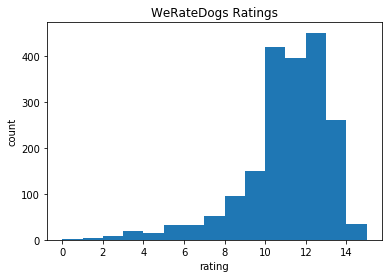

In [481]:
plt.hist(normal_denominator["rating_numerator"], range=(0,15), bins=15)
plt.xlabel("rating")
plt.ylabel("count")
plt.title("WeRateDogs Ratings")
plt.savefig("Dog_Ratings.png")

The vast majority of ratings are between 10 and 14. There are a couple outliers. 26, 27, and 75 are actually all decimals. The 11 and 9 were cut off. 420 is snoop dogg and 1776 is an Uncle Sam dog. 

In [482]:
def create_percentage(data, column, number):
    return sum(data[data[column]==number]["top_prediction_is_dog"]==True)/ len(data[data[column]==number])

In [483]:
percentage_pred_is_dog = []

for i in range(0, 15):
    percentage_pred_is_dog.append(create_percentage(normal_denominator, "rating_numerator", i))


In [484]:
numerator = range(0, 15)

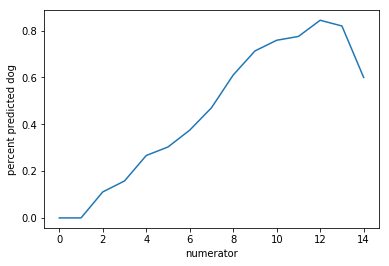

In [485]:
plt.plot(numerator, percentage_pred_is_dog)
plt.xlabel("numerator")
plt.ylabel("percent predicted dog")
plt.savefig("Is_Dog.png")

How can one get a high rating from WeRateDogs? It turns out actually sending a picture of something that is a dog is pretty important. 

In [486]:
normal_denominator[normal_denominator["rating_numerator"]==14]

,tweet_id,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,top_prediction,top_prediction_confidence,top_prediction_is_dog,second_prediction,second_prediction_confidence,second_prediction_is_dog,third_prediction,third_prediction_confidence,third_prediction_is_dog
9,890240255349198849,14,10,Cassie,doggo,None,None,None,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
21,887517139158093824,14,10,such,None,None,None,None,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False
36,884441805382717440,14,10,None,None,None,None,None,Pembroke,0.993225,True,Cardigan,0.003216,True,Chihuahua,0.002081,True
49,881536004380872706,14,10,a,None,None,pupper,None,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False
64,878057613040115712,14,10,Emmy,None,None,None,None,French_bulldog,0.839097,True,Boston_bull,0.078799,True,toy_terrier,0.015243,True
95,870063196459192321,14,10,Clifford,None,None,None,None,comic_book,0.534409,False,envelope,0.280722,False,book_jacket,0.043786,False
100,868880397819494401,14,10,Walter,None,None,None,None,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
113,864873206498414592,14,10,None,None,None,None,None,pole,0.478616,False,lakeside,0.114182,False,wreck,0.055926,False
119,863079547188785154,14,10,None,None,None,None,None,Lakeland_terrier,0.275242,True,Airedale,0.190569,True,teddy,0.102595,False
131,860184849394610176,14,10,None,None,None,None,None,chimpanzee,0.267612,False,gorilla,0.104293,False,orangutan,0.059908,False


In [487]:
tweet_data_clean[tweet_data_clean["tweet_id"]==685547936038666240]

,tweet_id,retweets,favorites,timestamp,source,text,hashtags,expanded_urls,name,jpg_url
713,685547936038666240,17133,35176,2016-01-08 19:45:39 +0000,Twitter for iPhone,"Everybody needs to read this, Jack is our firs...",None,https://twitter.com/dog_rates/status/685547936...,None,https://pbs.twimg.com/media/CYOONfZW8AA7IOA.jpg


In [488]:
tweet_data_clean[tweet_data_clean["tweet_id"]==685547936038666240]["expanded_urls"].iloc[0]

'https://twitter.com/dog_rates/status/685547936038666240/photo/1,https://twitter.com/dog_rates/status/685547936038666240/photo/1'

I don't want to show every tweet here, but I looked through a lot of them. A lot of the 14s are from news stories or videos, which the neural net likely could not predict correctly. 